In [1]:
# Start two meshcat server instances to use for the remainder of this notebook.
from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
proc_planar, zmq_url_planar, web_url_planar = start_zmq_server_as_subprocess(server_args=['--ngrok_http_tunnel'])
proc, zmq_url, web_url = start_zmq_server_as_subprocess(server_args=['--ngrok_http_tunnel'])

import numpy as np
from ipywidgets import FloatSlider, ToggleButton
from IPython.display import display, SVG
import pydot

import pydrake.all
from pydrake.all import (
    DiagramBuilder, LinearQuadraticRegulator, Saturation, SceneGraph, Simulator, 
    WrapToSystem, AddMultibodyPlantSceneGraph, Parser
)
from pydrake.examples.acrobot import AcrobotPlant, AcrobotGeometry
from pydrake.systems.jupyter_widgets import WidgetSystem
from pydrake.systems.primitives import ConstantVectorSource
from pydrake.common.containers import namedview

# Dynamics of the Acrobot

The acrobot is a core example in Drake.  We could certainly load it from a .urdf file, but Drake offers an Acrobot implementation that makes it convenient to manipulate the parameters (and visualize the system with different parameters).

In [13]:
builder = DiagramBuilder()
#acrobot = builder.AddSystem(AcrobotPlant())
acrobot, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
file_name = "double_pendulum.urdf"
Parser(acrobot).AddModelFromFile(file_name)
acrobot.Finalize()

# Setup visualization
visualizer = pydrake.systems.meshcat_visualizer.ConnectMeshcatVisualizer(
    builder, 
    scene_graph=scene_graph, 
    zmq_url=zmq_url_planar)
visualizer.vis.delete()
visualizer.set_planar_viewpoint(xmin=-4, xmax=4, ymin=-4, ymax=4)

# Setup slider input
u = np.array([-3,0])
torque_system = builder.AddSystem(ConstantVectorSource(u))
builder.Connect(torque_system.get_output_port(0), acrobot.get_input_port(3))

diagram = builder.Build()

# For reference, let's draw the diagram we've assembled:
#display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg()))

# Set up a simulator to run this diagram
simulator = Simulator(diagram)
context = simulator.get_mutable_context()

stop_button = ToggleButton(value=False, description='Stop Simulation')
display(stop_button)

# Set the initial conditions
context.SetContinuousState([0, 0, 0, 0]) # theta1, theta2, theta1dot, theta2dot
context.SetTime(0.0)

if True:  # Then we're not just running as a test on CI.
    simulator.set_target_realtime_rate(1.0)

    while not stop_button.value:
        simulator.AdvanceTo(simulator.get_context().get_time() + 1.0)
    stop_button.value = False
else:
    simulator.AdvanceTo(0.1)


Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6000...
You can open the visualizer by visiting the following URL:
http://cbf1-52-90-221-115.ngrok.io/static/
Connected to meshcat-server.


ToggleButton(value=False, description='Stop Simulation')

KeyboardInterrupt: 

# LQR for the Acrobot

In [ ]:
from pydrake.examples.acrobot import (AcrobotInput, AcrobotGeometry, 
                                      AcrobotPlant, AcrobotState)

def acrobot_balancing_example():
    def UprightState():
        state = AcrobotState()
        state.set_theta1(np.pi)
        state.set_theta2(0.)
        state.set_theta1dot(0.)
        state.set_theta2dot(0.)
        return state


    def BalancingLQR():
        # Design an LQR controller for stabilizing the Acrobot around the upright.
        # Returns a (static) AffineSystem that implements the controller (in
        # the original AcrobotState coordinates).

        acrobot = AcrobotPlant()
        context = acrobot.CreateDefaultContext()

        input = AcrobotInput()
        input.set_tau(0.)
        acrobot.get_input_port(0).FixValue(context, input)

        context.get_mutable_continuous_state_vector()\
            .SetFromVector(UprightState().CopyToVector())

        Q = np.diag((10., 10., 1., 1.))
        R = [1]

        return LinearQuadraticRegulator(acrobot, context, Q, R)


    builder = DiagramBuilder()
    acrobot = builder.AddSystem(AcrobotPlant())

    saturation = builder.AddSystem(Saturation(min_value=[-10], max_value=[10]))
    builder.Connect(saturation.get_output_port(0), acrobot.get_input_port(0))
    wrapangles = WrapToSystem(4)
    wrapangles.set_interval(0, 0, 2. * np.pi)
    wrapangles.set_interval(1, -np.pi, np.pi)
    wrapto = builder.AddSystem(wrapangles)
    builder.Connect(acrobot.get_output_port(0), wrapto.get_input_port(0))
    controller = builder.AddSystem(BalancingLQR())
    builder.Connect(wrapto.get_output_port(0), controller.get_input_port(0))
    builder.Connect(controller.get_output_port(0), saturation.get_input_port(0))

    # Setup visualization
    scene_graph = builder.AddSystem(SceneGraph())
    AcrobotGeometry.AddToBuilder(builder, acrobot.get_output_port(0), scene_graph)
    visualizer = pydrake.systems.meshcat_visualizer.ConnectMeshcatVisualizer(
        builder, 
        scene_graph=scene_graph, 
        zmq_url=zmq_url_planar)
    visualizer.vis.delete()
    visualizer.set_planar_viewpoint(xmin=-3.0, xmax=3.0, ymin=-3.0, ymax=4.0)

    diagram = builder.Build()

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    simulator.set_target_realtime_rate(1.0)
    context = simulator.get_mutable_context()

    # Simulate
    duration = 4.0 # sets a shorter duration during testing
    for i in range(5):
        context.SetTime(0.)
        context.SetContinuousState(UprightState().CopyToVector() +
                                0.05 * np.random.randn(4,))
        simulator.Initialize()
        simulator.AdvanceTo(duration)

acrobot_balancing_example()

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6002...
You can open the visualizer by visiting the following URL:
http://a4b1-52-90-221-115.ngrok.io/static/
Connected to meshcat-server.


# Balancing a 2D Segway (aka "ballbot")

I'll also use this example to illustrate a little more about how one might build a new model in drake (using multibody plant).  I've included the URDF in this notebook directly as a string so that you can see it and easily play with it.

https://en.wikipedia.org/wiki/Ballbot

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6003...
You can open the visualizer by visiting the following URL:
http://bc26-52-90-221-115.ngrok.io/static/
Connected to meshcat-server.


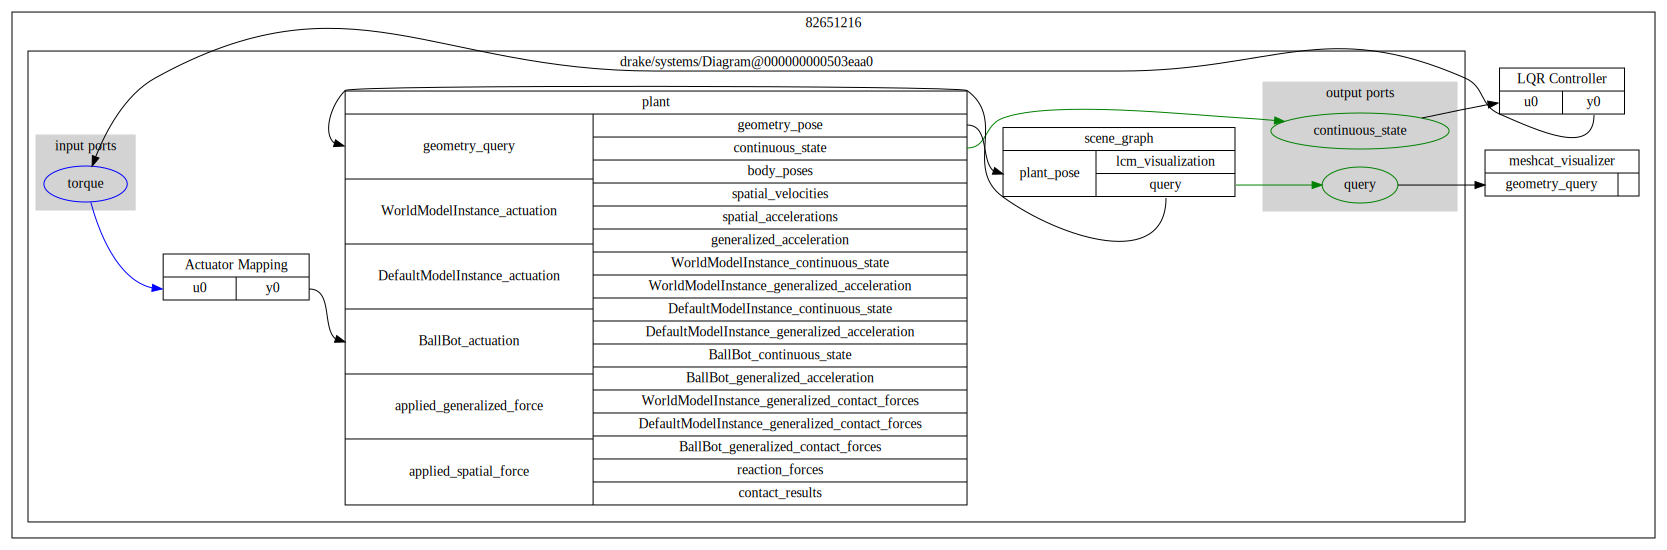

In [ ]:

ballbot_urdf = """
<?xml version="1.0"?>

<robot xmlns="http://drake.mit.edu"
 xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
 name="BallBot">

  <link name="ground">
    <visual>
      <origin xyz="0 0 -5" rpy="0 0 0" />
      <geometry>
        <box size="1000 1000 10" />
      </geometry>
      <material>
        <color rgba="0.93 .74 .4 1" />
      </material>
    </visual>
  </link>

  <joint name="ground_weld" type="fixed">
    <parent link="world" />
    <child link="ground" />
  </joint>

  <link name="ball">
    <inertial>
      <origin xyz="0 0 0" rpy="0 0 0" />
      <mass value="5" />
      <inertia ixx=".02" ixy="0" ixz="0" iyy="0.02" iyz="0" izz="0.02" />
    </inertial>
    <visual>
      <origin xyz="0 0 0" rpy="0 0 0" />
      <geometry>
        <sphere radius=".1" />
      </geometry>
      <material>
        <color rgba="0.25 0.52 0.96 1" />
      </material>
    </visual>
  </link>

  <link name="bot">
    <inertial>
      <origin xyz="0 0 .05" rpy="0 0 0" />
      <mass value="4" />
      <inertia ixx="0.018" ixy="0" ixz="0" iyy="0.018" iyz="0" izz="0.0288" />
    </inertial>
    <visual>
      <origin xyz="0 0 .05" rpy="0 0 0" />
      <geometry>
         <cylinder length=".1" radius=".12" />
      </geometry>
      <material>
        <color rgba=".61 .63 .67 1" />
      </material>
    </visual>
  </link>
  
  <joint name="x" type="prismatic">
    <parent link="world" />
    <child link="ball" />
    <origin xyz="0 0 .1" />
    <axis xyz="1 0 0" />
    <dynamics damping="0.1" />
  </joint>

  <joint name="theta" type="continuous">
    <parent link="ball" />
    <child link="bot" />
    <origin xyz="0 0 0" />
    <axis xyz="0 1 0" />
    <dynamics damping="0.1" />
  </joint>

  <transmission type="SimpleTransmission" name="ball_torque">
    <actuator name="torque" />
    <joint name="theta" />
    <mechanicalReduction>1</mechanicalReduction>
  </transmission>

  <transmission type="SimpleTransmission" name="ball_force">
    <actuator name="force" />
    <joint name="x" />
    <mechanicalReduction>.1</mechanicalReduction>
  </transmission>
</robot>
"""

def ballbot_example():
    def UprightState():
        state = (0, 0, 0, 0)
        return state


    def BalancingLQR(plant):
        # Design an LQR controller for stabilizing the CartPole around the upright.
        # Returns a (static) AffineSystem that implements the controller (in
        # the original CartPole coordinates).

        context = plant.CreateDefaultContext()
        plant.get_input_port().FixValue(context, [0])

        context.get_mutable_continuous_state_vector().SetFromVector(UprightState())

        Q = np.diag((10., 10., 1., 1.))
        R = [1]

        # MultibodyPlant has many (optional) input ports, so we must pass the
        # input_port_index to LQR.
        return LinearQuadraticRegulator(
            plant,
            context,
            Q,
            R)


    def MakeBallBot():
        builder = DiagramBuilder()
        plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
        Parser(plant).AddModelFromString(ballbot_urdf, "urdf")
        plant.Finalize()
        # Applying a torque between the ball and the bot torques the bot, but also causes a 
        # force at the ground (the radius of the ball is entered as a gear reduction in the transmission).
        B = np.array([[1],[1]])
        gain = builder.AddSystem(pydrake.systems.primitives.MatrixGain(B))
        gain.set_name("Actuator Mapping")
        builder.Connect(gain.get_output_port(), plant.get_actuation_input_port())
        builder.ExportInput(gain.get_input_port(), "torque")
        builder.ExportOutput(plant.get_state_output_port(), "continuous_state")
        builder.ExportOutput(scene_graph.get_query_output_port(), "query")
        return builder.Build()

    builder = DiagramBuilder()
    ballbot = builder.AddSystem(MakeBallBot())

    controller = builder.AddSystem(BalancingLQR(ballbot))
    controller.set_name("LQR Controller")
    builder.Connect(ballbot.GetOutputPort("continuous_state"), controller.get_input_port())
    builder.Connect(controller.get_output_port(),
                    ballbot.get_input_port())

    # Setup visualization
    visualizer = pydrake.systems.meshcat_visualizer.ConnectMeshcatVisualizer(
        builder, 
        output_port=ballbot.GetOutputPort("query"),
        zmq_url=zmq_url)
    visualizer.vis.delete()
    visualizer.vis['/Background'].set_property('visible', False)
    #visualizer.set_planar_viewpoint(xmin=-2.5, xmax=2.5, ymin=-1.0, ymax=2.5)

    diagram = builder.Build()
    
    # For reference, let's draw the diagram we've assembled:
    display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg()))

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    simulator.set_target_realtime_rate(1.0)
    context = simulator.get_mutable_context()
    context.SetContinuousState(UprightState() + 0.0 * np.random.randn(4,) + np.array([1, 0, 0 ,0]))

    # Simulate
    duration = 10.0
    simulator.AdvanceTo(duration)

ballbot_example()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5fd8e1d3-71c2-47d4-871c-7eed4e2b387c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>